# Music Culture and Psychological States
## Replicating and Expanding DeWall et al. 2011 "Tuning in to Psychological Change"<sup>1</sup>

DeWall et al. 2011 tested three music lyric legisign relationships for evidence that replication of self-focus and antisocial legisigns has increased over time in song lyrics from the Billboard Hot 100 and that the replication of other-focus, social interactions, and positive emotion legisigns has decreased. Confirming their expectations, they argue that this pattern in musical legisign replication can be generalized to say that U.S. culture has become more self-focused and antisocial. If we accept Frith's assertion that songs "provide people with the means to articulate [...] feelings" (1996: 164)<sup>2</sup>, then this finding of increasingly antisocial and self-focused language within the most popular U.S. songs should be suggestive of a more general cultural psychological state. In Peircean terms, this means that, on one level, each word in the lyrics would be a replica of a dicent indexical legisign. For instance, replications of "self-focus" I/me/my/mine words stand for singer singing the word (and for listener who uses the word to articulate their own feelings), indexing their internal psychological state, and producing a dicent interpretant associating that psychological state with themselves. Today, we're going to attempt to replicate and expand DeWall et al.'s study (using Billboard Hot 100 song lyrics from 1950-2015) by answering the following questions:

1. Can we identify increasing self-focus (first person singular pronouns) and decreasing other-focus ("communion," first person plural pronouns)?
2. Can we identify decreasing "social connection" legisign replication?
3. Is there an increase in antisocial legisign replication and a decrease in pro-social legisign replication?
4. Extending DeWall et al.'s study, are the topics and themes in songs changing as well? Do topics of music also reflect this anti-social, self-focus interpretation?

Our data comes from a couple (see [here](https://github.com/kevinschaich/billboard) and [here](https://towardsdatascience.com/billboard-hot-100-analytics-using-data-to-understand-the-shift-in-popular-music-in-the-last-60-ac3919d39b49)) of public Github repositories that compiled extensive historical data about the Billboard Hot 100 from 1950-2015, along with data about the music itself from Spotify.
    
Note: The authors of the study tested the frequency of Social Connection, Anti-social, Positive Emotion (unless the few words provided in the text on page 3 are the only words they checked) word categories using the LIWC (Language Inquiry Word Count) 2007 dictionary, which we will use as well. In the original study, DeWall et al. consider music genre as dummy variables in their regression models, as well as changes in ranking formula  to account for digital downloads and streamed media. We will not consider these factors for analysis as genre is a bit tricky to pin down because so many songs cross genre-boundaries, the genres themselves have changed through time, and this information is often not available in early songs from the 50s. We will instead consider the overall effects across genres and ranking formulas.
    
---------------------------------
  
<sup>1</sup>DeWall, C. N., Pond, R. S., Jr., Campbell, W. K., & Twenge, J. M. 2011. "Tuning in to Psychological Change: Linguistic Markers of Psychological Traits and Emotions Over Time in Popular U.S. Song Lyrics." *Psychology of Aesthetics*, Creativity, and the Arts.

<sup>2</sup>Frith, Simon. 1996. “Songs as Texts.” In *Performing Rites: On the Value of Popular Music*. Cambridge,
MA: Harvard University Press, pp. 158-182.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import nltk
import string
from gensim import corpora, models
import collections
import re

# Some Functions from Last Time to get us started:
def get_wordnet_pos(word):

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):

    stop = nltk.corpus.stopwords.words('english') + list(string.punctuation)
    tokens = [i for i in nltk.word_tokenize(text.lower()) if i not in stop]
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t)) for t in tokens]
    return lemmas

def get_tokens(text):
    # drop punctuation, but keep stopwords for initial word counting
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [i for i in nltk.word_tokenize(text.lower())]
    return tokens

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=8)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

def fill_topic_weights(df_row, bow_corpus):
    # Fill topic weights for topics in songs
    try:
        for i in ldamodel[bow_corpus[df_row.name]]:
            df_row[str(i[0])] = i[1]
    except:
        return df_row
    return df_row

def top_songs_by_topic(ldamodel, corpus, ntop=1):
    topn_songs_by_topic = {}
    for i in range(len(ldamodel.print_topics())):
        # For each topic, collect the most representative song(s) (i.e. highest probability containing words belonging to topic):
        top = sorted(zip(range(len(corpus)), ldamodel[corpus]), reverse=True, key=lambda x: abs(dict(x[1]).get(i, 0.0)))
        topn_songs_by_topic[i] = [j[0] for j in top[:ntop]]
        # Print out the topn songs for each topic and return their indices as a dictionary for further analysis:
        print("Topic " + str(i))
        print(music_df[['title','year','artist']].loc[topn_songs_by_topic[i]])
        print("*******************************")
    return topn_songs_by_topic

'''
The following code is adapted from psyLex.
psyLex: an open-source implementation of the Linguistic Inquiry Word Count
Created by Sean C. Rife, Ph.D.
srife1@murraystate.edu // seanrife.com // @seanrife
Licensed under the MIT License
https://github.com/seanrife/psyLex
'''

# Function to read in an LIWC-style dictionary

def readDict(dictionaryPath):
    catList = collections.OrderedDict()
    catLocation = []
    wordList = {}
    finalDict = collections.OrderedDict()

    # Check to make sure the dictionary is properly formatted
    with open(dictionaryPath, "r") as dictionaryFile:
        for idx, item in enumerate(dictionaryFile):
            if "%" in item:
                catLocation.append(idx)
        if len(catLocation) > 2:
            # There are apparently more than two category sections; throw error and die
            sys.exit("Invalid dictionary format. Check the number/locations of the category delimiters (%).")

    # Read dictionary as lines
    with open(dictionaryPath, "r") as dictionaryFile:
        lines = dictionaryFile.readlines()

    # Within the category section of the dictionary file, grab the numbers associated with each category
    for line in lines[catLocation[0] + 1:catLocation[1]]:
        catList[re.split(r'\t+', line)[0]] = [re.split(r'\t+', line.rstrip())[1]]

    # Now move on to the words
    for idx, line in enumerate(lines[catLocation[1] + 1:]):
        # Get each line (row), and split it by tabs (\t)
        workingRow = re.split('\t', line.rstrip())
        wordList[workingRow[0]] = list(workingRow[1:])

    # Merge the category list and the word list
    for key, values in wordList.items():
        if not key in finalDict:
            finalDict[key] = []
        for catnum in values:
            workingValue = catList[catnum][0]
            finalDict[key].append(workingValue)
    return (finalDict, catList.values())

# Function to count and categorize words based on an LIWC dictionary

def wordCount(data, dictOutput):
    finalDict, catList = dictOutput
    
    # Create a new dictionary for the output
    outList = collections.OrderedDict()

    # Number of non-dictionary words
    nonDict = 0

    # Convert to lowercase
    data = data.lower()

    # Tokenize and create a frequency distribution
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(data)

    fdist = nltk.FreqDist(tokens)
    wc = len(tokens)

    # Using the Porter stemmer for wildcards, create a stemmed version of the data
    porter = nltk.PorterStemmer()
    stems = [porter.stem(word) for word in tokens]
    fdist_stem = nltk.FreqDist(stems)

    # Access categories and populate the output dictionary with keys
    for cat in catList:
        outList[cat[0]] = 0

    # Dictionaries are more useful
    fdist_dict = dict(fdist)
    fdist_stem_dict = dict(fdist_stem)

    # Number of classified words
    classified = 0

    for key in finalDict:
        if "*" in key and key[:-1] in fdist_stem_dict:
            classified = classified + fdist_stem_dict[key[:-1]]
            for cat in finalDict[key]:
                outList[cat] = outList[cat] + fdist_stem_dict[key[:-1]]
        elif key in fdist_dict:
            classified = classified + fdist_dict[key]
            for cat in finalDict[key]:
                outList[cat] = outList[cat] + fdist_dict[key]

    # Calculate the percentage of words classified
    if wc > 0:
        percClassified = (float(classified) / float(wc)) * 100
    else:
        percClassified = 0

    # Return the categories, the words used, the word count, the number of words classified, and the percentage of words classified.
    return [outList, tokens, wc, classified, percClassified]

In [4]:
music_df = pd.read_csv('music_df.csv')
music_df['year_bin'] = music_df['year_bin'].apply(lambda x: '20'+x if (x == '10s') or (x == '00s') else '19'+x)

In [5]:
print(music_df.columns)
music_df.head()

Index(['lyrics', 'num_syllables', 'pos', 'year', 'fog_index', 'flesch_index',
       'num_words', 'num_lines', 'title', 'f_k_grade', 'artist',
       'difficult_words', 'num_dupes', 'neg', 'neu', 'compound', 'id',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'uri', 'analysis_url',
       'artist_with_features', 'year_bin', 'image', 'cluster', 'Gender'],
      dtype='object')


,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
0,"Mona Lisa, Mona Lisa, men have named you\nYou'...",189.0,0.199,1950,5.2,88.74,145,17,Mona Lisa,2.9,...,86.198,207573.0,3,spotify:track:3k5ycyXX5qsCjLd7R2vphp,https://api.spotify.com/v1/audio-analysis/3k5y...,NaN,1950s,https://i.scdn.co/image/a4c0918f13b67aa8d9f4ea...,String Lover,male
1,I wanna be Loved\nBy Andrews Sisters\n\nOooo-o...,270.9,0.224,1950,4.4,82.31,189,31,I Wanna Be Loved,3.3,...,170.869,198027.0,5,spotify:track:4UY81WrDU3jTROGaKuz4uZ,https://api.spotify.com/v1/audio-analysis/4UY8...,Gordon Jenkins,1950s,https://i.scdn.co/image/42e4dc3ab9b190056a1ca1...,String Lover,Group
2,I was dancing with my darling to the Tennessee...,174.6,0.351,1950,5.2,88.74,138,16,Tennessee Waltz,2.9,...,86.335,182733.0,3,spotify:track:6DKt9vMnMN0HmlnK3EAHRQ,https://api.spotify.com/v1/audio-analysis/6DKt...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female
3,Each time I hold someone new\nMy arms grow col...,135.9,0.231,1950,4.4,99.23,117,18,I'll Never Be Free,0.9,...,82.184,158000.0,3,spotify:track:0KnD456yC5JuweN932Ems3,https://api.spotify.com/v1/audio-analysis/0KnD...,Kay Starr,1950s,https://i.scdn.co/image/4bd427bb9181914d0fa448...,String Lover,male
4,"Unfortunately, we are not licensed to display ...",46.8,0.079,1950,6.0,69.79,32,3,All My Love,6.0,...,123.314,190933.0,4,spotify:track:05sXHTLqIpwywbpui1JT4o,https://api.spotify.com/v1/audio-analysis/05sX...,NaN,1950s,https://i.scdn.co/image/353b05113b1a140d64d83d...,String Lover,female


In [8]:
def first_p_sg_perc(text):
    text = get_tokens(text)
    first_p_sg_count = text.count('i') + text.count('me') + text.count('my') + text.count('mine')
    
    return first_p_sg_count/len(text)

def first_p_pl_perc(text):
    text = get_tokens(text)
    first_p_pl_count = text.count('we') + text.count('us') + text.count('our') + text.count('ours')
    
    return first_p_pl_count/len(text)

In [9]:
lyrics = music_df['lyrics']
agency = lyrics.apply(first_p_sg_perc)
communion = lyrics.apply(first_p_sg_perc)

In [10]:
liwc_dict = readDict("LIWC2007_English100131.dic")
liwc_counts = wordCount('This is fun!', liwc_dict)
liwc_counts[0]['posemo']/liwc_counts[2]

0.3333333333333333

In [12]:
def social_connection(text, liwc_dict):
    liwc_count = wordCount(text, liwc_dict)
    
    return liwc_counts[0]['social']/liwc_counts[2]

def antisocial_perc(text, liwc_dict):
    liwc_count = wordCount(text, liwc_dict)
    
    return (liwc_counts[0]['anger'] + liwc_counts[0]['swear'])/liwc_counts[2]

def positive_perc(text, liwc_dict):
    liwc_count = wordCount(text, liwc_dict)
    
    return liwc_counts[0]['posemo']/liwc_counts[2]

In [13]:
lyrics.apply(social_connection, args = [liwc_dict])

KeyboardInterrupt: 

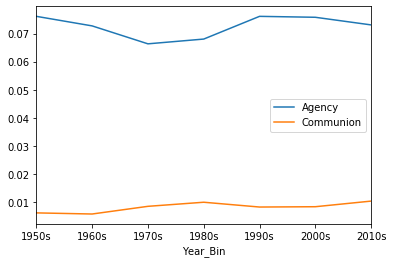

In [15]:
df = pd.read_csv('psych_percs.csv')
df[['Agency', 'Communion', 'Year_Bin']].groupby('Year_Bin').mean().plot();

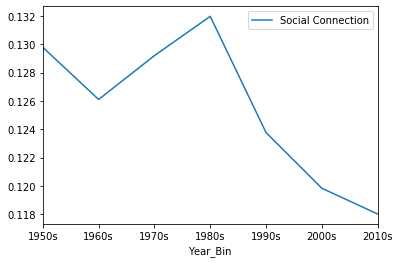

In [16]:
df[['Social Connection', 'Year_Bin']].groupby('Year_Bin').mean().plot();

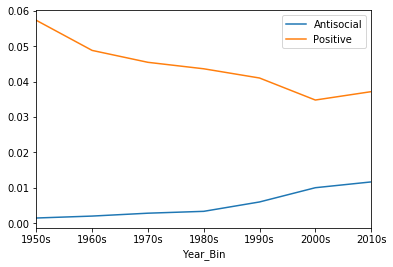

In [17]:
df[['Antisocial', 'Positive', 'Year_Bin']].groupby('Year_Bin').mean().plot();

In [18]:
mod = smf.ols(formula='Agency ~ Year', data = df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Agency   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.536
Date:                Thu, 13 Feb 2020   Prob (F-statistic):             0.0332
Time:                        13:03:40   Log-Likelihood:                 6911.1
No. Observations:                4028   AIC:                        -1.382e+04
Df Residuals:                    4026   BIC:                        -1.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0982      0.080     -1.227      0.2

In [22]:
lemmas = pd.read_pickle('lyric_lemmas.pkl')
lemmas[0][:10]

['mona',
 'lisa',
 'mona',
 'lisa',
 'men',
 'name',
 "'re",
 'like',
 'lady',
 'mystic']

In [23]:
bigram = models.Phrases(lemmas, min_count=5)

bigram_mod = models.phrases.Phraser(bigram)

print(bigram_mod[lemmas[0]])

['mona_lisa', 'mona_lisa', 'men', 'name', "'re", 'like', 'lady', 'mystic', 'smile', "'cause", "'re", 'lonely', 'blame', 'mona_lisa', 'strangeness', 'smile_smile', 'tempt', 'lover', 'mona_lisa', 'way', 'hide', 'broken_heart', 'many', 'dream', 'brought', 'doorstep', 'lie', 'die', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work_art', 'smile', 'tempt', 'lover', 'mona_lisa', 'way', 'hide', 'broken_heart', 'many', 'dream', 'brought', 'doorstep', 'lie', 'die', 'warm', 'real', 'mona_lisa', 'cold', 'lonely', 'lovely', 'work_art', 'mona_lisa', 'mona_lisa']


In [24]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

lemmas = make_bigrams(lemmas)

In [31]:
dictionary = corpora.Dictionary(i for i in lemmas)
bow_corpus = [dictionary.doc2bow(text) for text in lemmas]

In [32]:
ldamodel = models.ldamodel.LdaModel.load('lda5p20_i400.model')
topics = ldamodel.print_topics(num_words = 20)

for topic in topics:
    print(topic)

FileNotFoundError: [Errno 2] No such file or directory: 'lda5p20_i400.model.expElogbeta.npy'

In [ ]:
top_songs_by_topic = top_songs_by_topic(ldamodel, )

In [33]:
music_df = music_df.apply(fill_topic_weights, axis = 1, args = [bow_corpus]).fillna(0)
music_df.tail()

,lyrics,num_syllables,pos,year,fog_index,flesch_index,num_words,num_lines,title,f_k_grade,...,tempo,duration_ms,time_signature,uri,analysis_url,artist_with_features,year_bin,image,cluster,Gender
4023,(I guess right now you've got the last laugh)\...,570.6,0.120,2015,5.6,96.18,469,51,Here,2.1,...,123.909,199453.0,4,spotify:track:664gdARxaClFsoF5SXKOws,https://api.spotify.com/v1/audio-analysis/664g...,0,2010s,https://i.scdn.co/image/46677af3f55e432727e7bf...,Poetic,female
4024,My face above the water\nMy feet can't touch t...,169.2,0.184,2015,4.0,91.78,126,22,Waves,1.7,...,119.993,208133.0,4,spotify:track:5Sf3GyLEAzJXxZ5mbCPXTu,https://api.spotify.com/v1/audio-analysis/5Sf3...,Robin Schulz,2010s,https://i.scdn.co/image/261cf047c334ad684d0c8e...,String Lover,male
4025,You know from the moment she turned around\nSh...,217.8,0.067,2015,4.8,106.67,193,26,She Knows,0.1,...,139.988,214726.0,4,spotify:track:0XETcdHr7EkjfoZFSj6Asv,https://api.spotify.com/v1/audio-analysis/0XET...,Juicy J,2010s,https://i.scdn.co/image/d48ffaffc20a3c76f79d81...,Poetic,male
4026,Going out tonight\nChanges into something red\...,399.6,0.026,2015,4.0,83.32,296,52,Night Changes,2.9,...,120.001,226600.0,4,spotify:track:5O2P9iiztwhomNh8xkR9lJ,https://api.spotify.com/v1/audio-analysis/5O2P...,0,2010s,https://i.scdn.co/image/5bb443424a1ad71603c43d...,String Lover,Group
4027,I want you to breathe me in\nLet me be your ai...,378.0,0.189,2015,4.4,107.69,340,52,How Deep Is Your Love,-0.3,...,122.003,212640.0,4,spotify:track:22mek4IiqubGD9ctzxc69s,https://api.spotify.com/v1/audio-analysis/22me...,Disciples,2010s,https://i.scdn.co/image/7b4c05bee8c822c006b372...,String Lover,male


In [35]:
music_df[['0', '1', '2', '3', '4', 'year_bin']].groupby('year_bin').mean().plot();

KeyError: "['3', '4', '0', '1', '2'] not in index"